In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, confusion_matrix

from sklearn.svm import SVC 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier

In [3]:
# Import des différents fichiers csv
fraud_df = pd.read_csv("Fraud_Data.csv")
country_df = pd.read_csv("IpAddress_to_Country.csv")

## Exploration Data 

In [4]:
# On regarde les infos sur les colonnes de notre df
fraud_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   purchase_time   151112 non-null  object 
 3   purchase_value  151112 non-null  int64  
 4   device_id       151112 non-null  object 
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             151112 non-null  object 
 8   age             151112 non-null  int64  
 9   ip_address      151112 non-null  float64
 10  class           151112 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB


In [5]:
# Observation de données manquantes
fraud_df.isnull().values.any()

False

In [6]:
fraud_df.describe(include='all')

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
count,151112.000000,151112,151112,151112.000000,151112,151112,151112,151112,151112.000000,1.511120e+05,151112.000000
unique,NaN,151112,150679,NaN,137956,3,5,2,NaN,NaN,NaN
top,NaN,2015-04-12 18:43:36,2015-06-08 09:42:04,NaN,ZUSVMDEZRBDTX,SEO,Chrome,M,NaN,NaN,NaN
freq,NaN,1,3,NaN,20,60615,61432,88293,NaN,NaN,NaN
mean,200171.040970,NaN,NaN,36.935372,NaN,NaN,NaN,NaN,33.140704,2.152145e+09,0.093646
std,115369.285024,NaN,NaN,18.322762,NaN,NaN,NaN,NaN,8.617733,1.248497e+09,0.291336
min,2.000000,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,18.000000,5.209350e+04,0.000000
25%,100642.500000,NaN,NaN,22.000000,NaN,NaN,NaN,NaN,27.000000,1.085934e+09,0.000000
50%,199958.000000,NaN,NaN,35.000000,NaN,NaN,NaN,NaN,33.000000,2.154770e+09,0.000000
75%,300054.000000,NaN,NaN,49.000000,NaN,NaN,NaN,NaN,39.000000,3.243258e+09,0.000000


Text(0, 0.5, 'Frequency')

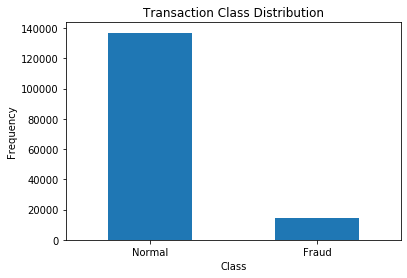

In [7]:
# Observation du ratio non-fraudre/fraude
LABELS = ["Normal", "Fraud"]
count_classes = pd.value_counts(fraud_df["class"], sort = True)
count_classes.plot(kind="bar", rot=0)
plt.title("Transaction Class Distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")

On peut observer que dans notre dataset, la quantité de fraude est très basse

In [8]:
# Observons plus précisément le pourcentage de fraude
def calc_prevalence(y):
 return (sum(y)/len(y))

pourcentage = calc_prevalence(fraud_df["class"].values*100)



In [9]:
print("Le pourcentage de fraude est de {}%".format(pourcentage))

Le pourcentage de fraude est de 9.364577267192546%


In [10]:
fraud_df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [11]:
country_df.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [12]:
# Nous allons attribuer le pays à son adresse ip et la rajouter à notre dataset principal
def ip_to_country(ip=None):
    try :
        return country_df.country[(country_df.lower_bound_ip_address <= ip) 
                             & (country_df.upper_bound_ip_address >= ip)].iloc[0]
    except IndexError :
        return "Unknown"     
# To affect a country to each IP :
fraud_df["ip_country"] = fraud_df.ip_address.apply(ip_to_country)

In [13]:
fraud_df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,ip_country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Unknown
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


# Observations

- Pas de valeurs manquantes
- Transformer la colonne purchase_time et signup_time pour pouvoir les utiliser en créant une nouvelle colonne delta_fraud
- variable cible : "class"
- variables explicatives : 'ip_country', "sex", "delta_fraud","purchase_value"


In [19]:
# On va créer une nouvelle colonne qui donne la différence entre 
# la colonne signup_time et purchase_time pour savoir combien de temps s'est écoulé s'il y a eu fraude ou non 
fraud_df["purchase_time"] = pd.to_datetime(fraud_df["purchase_time"], format = "%Y-%m-%d %H:%M:%S")
fraud_df["signup_time"] = pd.to_datetime(fraud_df["signup_time"], format = "%Y-%m-%d %H:%M:%S")


In [20]:
fraud_df["delta_fraud"] = (fraud_df["purchase_time"]-fraud_df["signup_time"]).dt.total_seconds()/(60*60*24)

In [21]:
#Arrondissement de la colonne pour simplifier la colonne
fraud_df["delta_fraud"]= fraud_df["delta_fraud"].astype(int)
fraud_df["delta_fraud"].round(1)

0         52
1          0
2          0
3          5
4         50
          ..
151107    60
151108    10
151109    77
151110    59
151111    40
Name: delta_fraud, Length: 151112, dtype: int64

/Users/soulemanecheckmouhammad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  
/Users/soulemanecheckmouhammad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


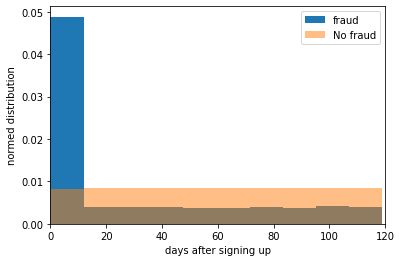

In [22]:
plt.hist(fraud_df.loc[fraud_df["class"] == 1,'delta_fraud'], 
 label = 'fraud', normed = True)
plt.hist(fraud_df.loc[fraud_df["class"] == 0,'delta_fraud'], 
 label = 'No fraud', normed = True,alpha =0.5)
plt.legend()
plt.xlabel('days after signing up')
plt.ylabel('normed distribution')
plt.xlim(0,120)
plt.show()

On observe que les fraudes sont souvent faites peu de temps après l'inscription

In [23]:
# Nous allons préparer notre dataset pour l'entrainement 
features_list = ['ip_country', "sex", "age", "delta_fraud","purchase_value"]
numeric_indices = [2,3]
categorical_indices = [0,1]
target_variable = 'class'    

In [24]:
X = fraud_df.loc[:, features_list]
Y = fraud_df.loc[:, target_variable]

print('Variables explicatives : ', X.columns)
print()

Variables explicatives :  Index(['ip_country', 'sex', 'age', 'delta_fraud', 'purchase_value'], dtype='object')



In [25]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [26]:
# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X_train = X_train.values
X_test = X_test.values
Y_train = Y_train.values
Y_test = Y_test.values
print("...Done")

print(X_train[0:5,:])
print(X_test[0:4,:])
print()
print(Y_train[0:5])
print(Y_test[0:2])

Convert pandas DataFrames to numpy arrays...
...Done
[['Unknown' 'M' 27 23 55]
 ['United States' 'M' 23 14 34]
 ['United States' 'F' 38 8 19]
 ['Unknown' 'M' 40 90 23]
 ['Japan' 'M' 29 98 16]]
[['Japan' 'F' 32 98 22]
 ['Unknown' 'M' 32 25 38]
 ['Sweden' 'M' 19 98 60]
 ['United States' 'F' 34 112 13]]

[0 0 0 0 0]
[0 0]


## Training pipeline

In [27]:
# Encoding categorical features and standardizing numerical features
print("Encoding categorical features and standardizing numerical features...")
print()
print(X_train[0:5,:])

# Normalization
numeric_transformer = StandardScaler()

# OHE / dummyfication
categorical_transformer = OneHotEncoder(handle_unknown = 'ignore')

featureencoder = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_indices),    
        ('num', numeric_transformer, numeric_indices)
        ]
    )

X_train = featureencoder.fit_transform(X_train)
print("...Done")
print(X_train[0:5,:])

Encoding categorical features and standardizing numerical features...

[['Unknown' 'M' 27 23 55]
 ['United States' 'M' 23 14 34]
 ['United States' 'F' 38 8 19]
 ['Unknown' 'M' 40 90 23]
 ['Japan' 'M' 29 98 16]]
...Done
  (0, 169)	1.0
  (0, 180)	1.0
  (0, 181)	-0.7131815211759088
  (0, 182)	-0.9296253241173461
  (1, 168)	1.0
  (1, 180)	1.0
  (1, 181)	-1.1773860038961057
  (1, 182)	-1.178508077068027
  (2, 168)	1.0
  (2, 179)	1.0
  (2, 181)	0.5633808063046324
  (2, 182)	-1.3444299123684809
  (3, 169)	1.0
  (3, 180)	1.0
  (3, 181)	0.7954830476647308
  (3, 182)	0.9231685034043895
  (4, 84)	1.0
  (4, 180)	1.0
  (4, 181)	-0.48107927981581045
  (4, 182)	1.144397617138328


## Random Forest

In [28]:
# Train model
print("Train model...")

clf_rdm = RandomForestClassifier()

clf_rdm.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


In [29]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = clf_rdm.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]



## Test Pipeline

In [30]:
# Encoding categorical features and standardizing numerical features
print("Encoding categorical features and standardizing numerical features...")
print()
print(X_test[0:5,:])


X_test = featureencoder.transform(X_test)
print("...Done")
print(X_test[0:5,:])

Encoding categorical features and standardizing numerical features...

[['Japan' 'F' 32 98 22]
 ['Unknown' 'M' 32 25 38]
 ['Sweden' 'M' 19 98 60]
 ['United States' 'F' 34 112 13]
 ['Canada' 'M' 27 46 56]]
...Done
  (0, 84)	1.0
  (0, 179)	1.0
  (0, 181)	-0.13292591777566282
  (0, 182)	1.144397617138328
  (1, 169)	1.0
  (1, 180)	1.0
  (1, 181)	-0.13292591777566282
  (1, 182)	-0.8743180456838614
  (2, 153)	1.0
  (2, 180)	1.0
  (2, 181)	-1.6415904866163025
  (2, 182)	1.144397617138328
  (3, 168)	1.0
  (3, 179)	1.0
  (3, 181)	0.09917632358443558
  (3, 182)	1.5315485661727206
  (4, 32)	1.0
  (4, 180)	1.0
  (4, 181)	-0.7131815211759088
  (4, 182)	-0.29359162213227263


In [31]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = clf_rdm.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



In [32]:
clf_rdm.score(X_test, Y_test)

0.9447875766532845

## Performent assessment 

In [33]:
# WARNING : Use the same score as the one that will be used by Kaggle !
# Here, the f1-score will be used to assess the performances on the leaderboard
# F1_score without boosting and feature engeenearing
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.8107679229243412
f1-score on test set :  0.6489973355770579


Nous sommes dans un cadre d'overfitting nous allons faire appel aux méthode de Voting et Stacking pour améliorer notre score

## Voting Classifier

In [35]:
from sklearn.ensemble import VotingClassifier
clf = VotingClassifier(
    estimators = [
                  ("tree", RandomForestClassifier(criterion="gini",random_state=42)),
                  ("svc", SVC())
                  ]
)

In [36]:
# Only random forest
clf.fit(X_train, Y_train)
clf.score(X_test, Y_test)

0.9468831340715578

In [37]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = clf.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]



In [38]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = clf.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



In [39]:
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.617627390664705
f1-score on test set :  0.618020304568528


## Stacking classifier

In [40]:
from sklearn.ensemble import StackingClassifier
clf = StackingClassifier(
     estimators = [
                  ("tree", RandomForestClassifier(criterion="gini",random_state=42)),
                  ("svc", SVC()), 
                  ]
)

In [41]:
# Only random forest
clf.fit(X_train, Y_train)
clf.score(X_test, Y_test)

0.9524859928530462

In [42]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = clf.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]



In [43]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = clf.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



In [45]:
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.6834450486910332
f1-score on test set :  0.6787951088577393


On obtient un meilleur score en utilisant le stacking